# Metadata

* Title:           **Final Project Report**
* Class:           DS 5100
* Date:            15 July 2022
* Student Name:    Rory Black
* Student Net ID:  qmn9tb
* This URL:        https://github.com/roryblakc/FinalProject-DS5100/blob/main/FinalProjectSubmission.ipynb
* GitHub Repo URL: https://github.com/roryblakc/FinalProject-DS5100

# The Monte Carlo Module

In [4]:
import numpy as np
import pandas as pd
import random

class Die:
    '''Create a Die object to then be able to change the weight of any faces and simulate rolling the die. Object is initialized with the input of an array of faces.'''
    def __init__(self, faces):
        '''Create a Die object with input parameter of an array of faces. Weights default to 1 for every face. No return value.'''
        self.faces = faces
        self.weights = np.ones(len(faces))
        self.die_df = pd.DataFrame({
            'face': self.faces,
            'weight': self.weights})
        
    def change_weight(self, face, weight):
        '''Allows the user to change the weight for any face of a Die object. Input parameters are a face and changed weight. Returns nothing.'''
        if face in self.faces:
            # index to weight for index of face
            # change weight
            if type(weight) == float or type(weight) == int:
                weight = float(weight)
                index = np.where(self.faces == face)
                self.weights[index] = weight
                # update df with new weight
                self.die_df['weight'] = self.weights 
            else:
                return("The weight needs to entered as a number.")
        else:
            return("This is not a valid face.")
        
    def roll(self, num_rolls=1):
        '''Allows user to simulate rolling a single die. Input parameter is how many rolls. Returns the list of faces produced on all rolls.'''
        rolls_list = random.choices(self.faces, weights=self.weights, k=num_rolls)
        return rolls_list
    
    def show_current(self):
        '''Returns a dataframe with the current faces and corresponding weights of a Die object.'''
        return self.die_df
    
class Game:
    '''Create a Game object from a list of one or more Die objects of the same kind to simulate rolling multiple dice.'''
    # all die in die list must have same faces
    def __init__(self, die_list):
        '''Create a Game object with input parameter of a list of Die objects of the same kind. No return value.'''
        self.die_list = die_list
    
    def play(self, num_rolls):
        '''Allows user to simulate rolling multiple dice at once. Input parameter is the number of rolls as an int. No return value.'''
        self._play_df = pd.DataFrame()
        # iterate through die and append rolls to df
        for die in self.die_list:
            die_rolls = die.roll(num_rolls)
            die_rolls = pd.Series(die_rolls)
            self._play_df = pd.concat([self._play_df, die_rolls], axis=1)
        # name columns with die number
        dice_number = range(1, len(self.die_list)+1)
        # list to rename columns in df with "Die __" format
        self.column_names = ["Die " + str(d) for d in dice_number]
        self._play_df.columns = self.column_names
        # name rows with roll number
        roll_number = range(1, num_rolls+1)
        # loop to rename rows in df with "Roll __" format
        self.row_names = ["Roll # " + str(r) for r in roll_number]
        self._play_df.index = self.row_names
    
    def show_play(self, form='wide'):
        '''Allows user to see results of the .play() method as a dataframe. Input parameter is either "wide" or "narrow". Returns a dataframe in the correct format.'''
        # exception if user does not pass wide or narrow
        form = form.lower()
        try:
            if form == 'wide':
                return(self._play_df)
            elif form == 'narrow':
                narrow_df = self._play_df.stack()
                narrow_df = pd.DataFrame(narrow_df)
                narrow_df.columns = ['Face Returned']
                return(narrow_df)
        except:
            print('Must specify either "wide" or "narrow".')
        
class Analyzer:
    '''Create an Analyzer object to reveal information about a Game object. Object is initialized with the input of an existing Game object.'''
    def __init__(self, game):
        '''Create an Analyzer obejct with the input of an already existing Game object. No return value.'''
        self.game = game
        self.face_dtype = type(self.game.die_list[0].faces[0])
        
    def jackpot(self):
        '''Allows user to see how many rolls resulted in all die returning the same face. The number of jackpots among all rolls is returned as an integer.'''
        # returns number of jackpots
        self.num_jackpots = 0
        # empty df for jackpots by roll
        self.jackpot_df = pd.DataFrame(index = self.game.row_names, columns = ['Jackpot'])
        # if only one value returned for all dice same roll, jackpot
        for i in range(len(self.game._play_df.index)):
            if (len(self.game._play_df.iloc[i].value_counts()) == 1):
                # add true to df for roll #
                self.jackpot_df.iat[i, 0] = True
                # increment num_jackpots by 1
                self.num_jackpots += 1
            else:
                # add false to df for roll #
                self.jackpot_df.iat[i, 0] = False
        return self.num_jackpots
    
    def combo(self):
        '''Allows user to view the counts for each combination of faces returned each roll. No return value, but .combo_df is an accessible attribute of any instance.'''
        # make multi-index df of combo counts
        self.combo_df = pd.DataFrame(self.game._play_df.groupby(self.game.column_names).size())
        self.combo_df.columns = ['Counts']
        
    def face_counts_per_roll(self):
        '''Allows user to view the counts of which faces were returned with each roll. No return value, but .face_counts_df is an accessible attribute of any instance.'''
        self.face_counts_df = pd.DataFrame()
        # append rolls row by row
        for x in self.game.row_names:
            self.face_counts_df = pd.concat([self.face_counts_df, self.game._play_df.T[x].value_counts()], axis=1)
        # fill all nan values with 0 and make all values ints
        self.face_counts_df = self.face_counts_df.fillna(0)
        self.face_counts_df = self.face_counts_df.astype(int)
        # transpose to make columns = faces, rows = roll #
        self.face_counts_df = self.face_counts_df.T

# Test Module

In [6]:
from montecarlo import Die, Game, Analyzer
import unittest
import numpy as np
import pandas as pd

class MonteCarloTestSuite(unittest.TestCase):    
    
    # DIE class tests

    def test_die_init(self):
        # create Die instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        
        # test
        actual_dim = d1.die_df.shape
        expected = (6,2)
        
        message = "The size of the dataframe constructed from initial faces and weights is not equal to the expected dimensions."
        
        # assertEqual() to check that faces and weights correctly initialized
        self.assertEqual(actual_dim, expected, message)
    
    def test_change_weight(self):
        # create Die instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        # change the weight of a face
        d1.change_weight(1,10)
        
        # test
        actual_weight = d1.weights[0]
        expected = 10
            
        message = "The weight was not correctly reassigned."
        
        # assertEqual() to check weight is equal to expected
        self.assertEqual(actual_weight, expected, message)
    
    def test_roll(self):
        # create Die instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        # roll die
        roll = d1.roll(20)
        
        # test
        actual_length = len(roll)
        expected = 20
        
        message = "The number of rolls requested was not executed."
        
        # assertEqual() to check length of roll list is correct
        self.assertEqual(actual_length, expected, message)
        
    def test_show_current(self):
        # create Die instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        
        # test
        if d1.show_current().shape == (6,2):
            test_value = True
        else:
            test_value = True
        
        message = "The dataframe returned does not have the expected dimensions."
        
        # assertTrue() to check that dimensions of dataframe equal the expected dimensions
        self.assertTrue(test_value, message)
        
    
    #########################################################################################
    # GAME class tests
    
    def test_game_init(self):
        # create Game instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        # test
        if len(game.die_list) == 3 and isinstance(game.die_list, list):
            test_value = True
        else:
            test_value = False
        
        message = "The Game object was not initialized with a list of the expected length."
        
        # assertTrue() to check that Game object is initialized with a list.
        self.assertTrue(test_value, message)
    
    def test_play(self):
        # create Game instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        # test
        if game._play_df.shape == (10, 3):
            test_value = True
        else:
            test_value = False
        
        message = "The dataframe returned does not have the expected dimensions."
        
        # assertTrue() to check that dimensions of dataframe equal the expected dimensions
        self.assertTrue(test_value, message)
        
    def test_show_play(self):
        # create Game instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        # test
        actual_dim = game.show_play('narrow').shape
        expected = (30, 1)
        
        message = "The dataframe returned does not have the expected dimensions."
        
        # assertEqual() to check that dimensions of dataframe equal the expected dimensions
        self.assertEqual(actual_dim, expected, message)
        
        
    #########################################################################################
    # ANALYZER class tests
    
    def test_analyzer_init(self):
        # create Analyzer instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        analyzer = Analyzer(game)
        
        # test
        if isinstance(analyzer.game, Game):
            test_value = True
        else:
            test_value = False
            
        message = "The Analyzer object was not initialized with an already existing Game object."
        
        # assertTrue() to check that Analyzer is initialized with a Game object as the input parameter
        self.assertTrue(test_value, message)
    
    def test_jackpot(self):
        # create Analyzer instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        analyzer = Analyzer(game)
        jackpot = analyzer.jackpot()
        
        # test
        if isinstance(analyzer.jackpot_df['Jackpot'][0], bool):
            test_value = True
        else:
            test_value = False
            
        message = "The column of jackpot results should be of type boolean."
        
        # assertTrue() to check that dataframe contains booleans for jackpot result
        self.assertTrue(test_value, message)
        
    def test_combo(self):
        # create Analyzer instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        analyzer = Analyzer(game)
        analyzer.combo()
        
        # test
        if isinstance(analyzer.combo_df.index, pd.core.indexes.multi.MultiIndex):
            test_value = True
        else:
            test_value = False
            
        message = "The dataframe does not appear to have multiple indices."
        
        # assertTrue() to check that dataframe actually does have multiple indices
        self.assertTrue(test_value, message)
        
    def test_face_counts_per_roll(self):
        # create Analyzer instance
        six_faces = np.array([1,2,3,4,5,6])
        d1 = Die(six_faces)
        die_list = [d1, d1, d1]
        game = Game(die_list)
        
        game.play(10)
        
        analyzer = Analyzer(game)
        analyzer.face_counts_per_roll()
        
        # test
        if analyzer.face_counts_df.shape == (10, 6):
            test_value = True
        else:
            test_value = False
            
        message = "The dataframe of face counts per roll does not have the correct dimensions."
        
        # assertTrue() to check that dataframe is the correct size and contains all rolls and faces
        self.assertTrue(test_value, message)

if __name__ == '__main__':
    unittest.main(verbosity=3)

ModuleNotFoundError: No module named 'montecarlo'

# Test Results

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1

In [20]:
from montecarlo import Die, Game, Analyzer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Create 2 coin objects.

In [11]:
coin_faces = np.array(['H','T'])
coin1 = Die(coin_faces)
coin2 = Die(coin_faces)
coin2.change_weight('H', 5)

Create a coin game with 3 fair coins.

In [13]:
coin_list = [coin1, coin1, coin1]
coin_game = Game(coin_list)
coin_game.play(1000)

Create analyzer object to determine the frequency of jackpots.

In [14]:
coin_analyzer = Analyzer(coin_game)
jackpot1 = coin_analyzer.jackpot()
print(f"Number of jackpots: {jackpot1}")

Number of jackpots: 264


In [15]:
print(f"Percentage of rolls that are jackpots: {coin_analyzer.jackpot()/len(coin_analyzer.jackpot_df)}")

Percentage of rolls that are jackpots: 0.264


Create a coin game with 2 unfair coins and 1 fair.

In [16]:
coin_list1 = [coin1, coin2, coin2]
coin_game1 = Game(coin_list1)
coin_game1.play(1000)

Create analyzer object to determine the frequency of jackpots.

In [17]:
coin_analyzer1 = Analyzer(coin_game1)
jackpot2 = coin_analyzer1.jackpot()
print(f"Number of jackpots: {jackpot2}")

Number of jackpots: 346


In [18]:
print(f"Percentage of rolls that are jackpots: {coin_analyzer1.jackpot()/len(coin_analyzer1.jackpot_df)}")

Percentage of rolls that are jackpots: 0.346


Two frequencies compares in a simple bar chart.

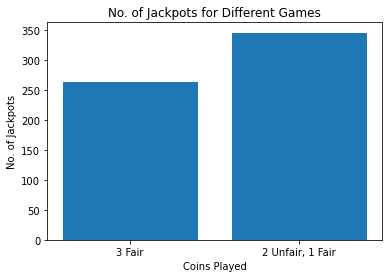

In [21]:
data = {'3 Fair':jackpot1, '2 Unfair, 1 Fair':jackpot2}
coins = list(data.keys())
jackpots = list(data.values())
plt.bar(coins, jackpots)
plt.title("No. of Jackpots for Different Games")
plt.ylabel("No. of Jackpots")
plt.xlabel("Coins Played")
plt.show()

## Scenario 2

Create 3 different Die objects. One fair and two unfair.

In [22]:
die_faces = np.array([1,2,3,4,5,6])
die1 = Die(die_faces)
die2 = Die(die_faces)
die2.change_weight(6, 5)
die3 = Die(die_faces)
die3.change_weight(1, 5)

Create a die game with 5 fair dice.

In [23]:
die_list1 = [die1, die1, die1, die1, die1]
die_game1 = Game(die_list1)
die_game1.play(1000)

Create analyzer object to determine frequency of jackpots.

In [24]:
die_analyzer1 = Analyzer(die_game1)
die_jackpot1 = die_analyzer1.jackpot()
print(f"Number of jackpots: {die_jackpot1}")

Number of jackpots: 0


Create a die game with 2 unfair dice of type 1, 1 unfair die of type 2, and 2 fair dice.

In [25]:
die_list2 = [die1, die1, die2, die2, die3]
die_game2 = Game(die_list2)
die_game2.play(1000)

Create analyzer object to determine frequency of jackpots.

In [26]:
die_analyzer2 = Analyzer(die_game2)
die_jackpot2 = die_analyzer2.jackpot()
print(f"Number of jackpots: {die_jackpot2}")

Number of jackpots: 3


Compare jackpot results in a bar chart.

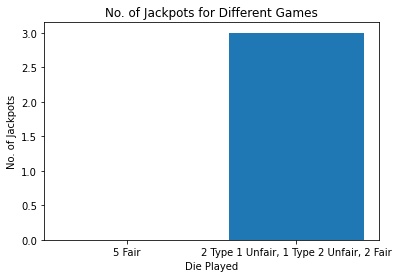

In [27]:
data = {'5 Fair':die_jackpot1, '2 Type 1 Unfair, 1 Type 2 Unfair, 2 Fair':die_jackpot2}
die = list(data.keys())
jackpots = list(data.values())
plt.bar(die, jackpots)
plt.title("No. of Jackpots for Different Games")
plt.ylabel("No. of Jackpots")
plt.xlabel("Die Played")
plt.show()

Plot 10 most frequent combinations of faces for the fair game.

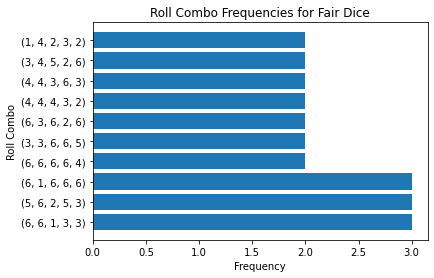

In [28]:
die_analyzer1.combo()
data = die_analyzer1.combo_df.sort_values(by=['Counts'], ascending=False).head(10)
counts1 = list(data['Counts'])
index1 = [str(data.index[i]) for i in range(10)]
plt.barh(index1, counts1)
plt.xlabel("Frequency")
plt.ylabel("Roll Combo")
plt.title("Roll Combo Frequencies for Fair Dice")
plt.show()

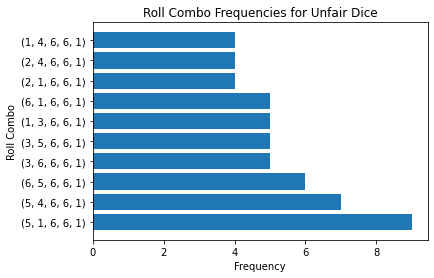

In [29]:
die_analyzer2.combo()
data = die_analyzer2.combo_df.sort_values(by=['Counts'], ascending=False).head(10)
counts2 = list(data['Counts'])
index2 = [str(data.index[i]) for i in range(10)]
plt.barh(index2, counts2)
plt.xlabel("Frequency")
plt.ylabel("Roll Combo")
plt.title("Roll Combo Frequencies for Unfair Dice")
plt.show()

## Scenario 3

Create a Die object with letters as faces.

In [35]:
alphabet = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
letters = Die(alphabet)
letters_freq = np.array([8.4966, 2.072, 4.5388, 3.3844, 11.1607, 1.8121, 2.4705, 3.0034, 7.5448, 0.1965, 1.1016, 5.4893, 3.0129, 6.6544, 7.1635, 3.1671, 0.1962, 7.5809, 5.7351, 6.9509, 3.6308, 1.0074, 1.2899, 0.2902, 1.777, 0.2722])

for i in range(len(alphabet)):
    letters.change_weight(str(alphabet[i]), letters_freq)

Play a game with 5 dice and 1000 rolls.

In [36]:
letters_list = [letters, letters, letters, letters, letters]
letters_game = Game(letters_list)
letters_game.play(1000)

Count how many of the combinations make actual English words.

In [37]:
pd.set_option('display.max_rows', 1000)
#letters_game.show_play()

Approximately 14 of the 1000 combinations made up an English-sounding word.

On average, it appears that somewhere between 12 to 20 of the 1000 combinations make up an English-sounding word.

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [ ]:
!ls -lRF -o

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [ ]:
# Installation commands